This notebook loads the combined datasets into combined_x/y 
Then it uses the SMOTE (Synthetic Minority Over-sampling Technique) to balance the data set with adding synthetic samples to lower count classes by interpolating between neighboring instances of the minority class. Specifically, for each minority class example, SMOTE selects one or more of its nearest neighbors and creates synthetic examples by interpolating between the feature vectors of the example and its neighbors. This results in a larger set of minority class examples that better represent the distribution of the original minority class.

This enables us to combine datasets without dealing with balancing the combined dataset to prevent fixations on a certain prediction

Then it utilazes the tuner.get_best_models() method to easily identify the best performing model and use it for prediction or further analysis.
It saves the best model to later use

#TO-DO

1.try ADASYN instead of SMOTE

#Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd                       #reading, writing and manipulating the data (using tables)
import numpy as np                        #Library for linear algebra and some probabiltity (raw data)
import tensorflow as tf                       
from keras.models import Sequential       #To create the sequential layer
from tensorflow.keras.callbacks import EarlyStopping

#from keras.layers.core import Flatten, Dense, Dropout     #To create the model
#from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D  #To create the model
from keras.preprocessing import image             #used for image classification
from keras.preprocessing.image import ImageDataGenerator  #used to expand the training dataset in order to improve the performance and ability of the model to generalize

from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import SGD, Adam          #To use the optimizer
from keras.utils import np_utils  

In [3]:
cx = [[],[],[],[],[],[]]
cy = [[],[],[],[],[],[]]

for i in range(0,6):

  # Load arrays from disk
  cx[i] = np.load('/content/drive/MyDrive/cxcy/cx'+str(i)+'.npy')
  cy[i] = np.load('/content/drive/MyDrive/cxcy/cy'+str(i)+'.npy')

In [4]:
for i in range(0,6):
  # print the shape of the combined array
  print(cx[i].shape)
  print(cy[i].shape)

(7872, 48, 48, 1)
(7872, 6)
(4283, 48, 48, 1)
(4283, 6)
(18426, 48, 48, 1)
(18426, 6)
(9841, 48, 48, 1)
(9841, 6)
(8727, 48, 48, 1)
(8727, 6)
(18389, 48, 48, 1)
(18389, 6)


In [5]:
combined_X = np.vstack((cx[0],cx[1],cx[2],cx[3],cx[4],cx[5]))
combined_y = np.vstack((cy[0],cy[1],cy[2],cy[3],cy[4],cy[5]))

In [6]:
  print(combined_X.shape)
  print(combined_y.shape)

(67538, 48, 48, 1)
(67538, 6)


This makes sure that the validation set is made out of equal smaples of each class

In [7]:
from imblearn.over_sampling import SMOTE

# Reshape the input data to a 2D array
X_train_res_2d = combined_X.reshape(combined_X.shape[0], -1)

# Apply SMOTE to balance the dataset
smote = SMOTE()
combined_X, combined_y = smote.fit_resample(X_train_res_2d, combined_y)

# Reshape the input data back to its original shape
combined_X = combined_X.reshape(combined_X.shape[0], 48, 48, 1)


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (75/25 split)
X_train, X_test, y_train, y_test = train_test_split(combined_X, combined_y, test_size=0.10, stratify=combined_y, random_state=42)

# Split the training set into training and validation sets (90/10 split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# Print the shape of the resulting datasets
print("Training set: X_train={}, y_train={}".format(X_train.shape, y_train.shape))
print("Validation set: X_val={}, y_val={}".format(X_val.shape, y_val.shape))
print("Test set: X_test={}, y_test={}".format(X_test.shape, y_test.shape))


Training set: X_train=(74625, 48, 48, 1), y_train=(74625, 6)
Validation set: X_val=(24875, 48, 48, 1), y_val=(24875, 6)
Test set: X_test=(11056, 48, 48, 1), y_test=(11056, 6)


#Creating the model

In [ ]:
!pip install keras-tuner

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (48, 48, 1)

# Define the number of classes
num_classes = 6

# Define the hypermodel function for the tuner
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of filters in the first convolutional layer
    hp_filters = hp.Choice('filters', values=[64])

    # Tune the size of the kernel in the first convolutional layer
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])

    # Tune the activation function
    hp_activation = hp.Choice('activation', values=['relu', 'elu'])

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3])

    # Tune the L2 regularization parameter
    hp_l2 = hp.Choice('l2', values=[0.001])

    # Add the first convolutional layer
    model.add(layers.Conv2D(hp_filters, hp_kernel_size, activation=hp_activation, input_shape=input_shape, kernel_regularizer=l2(hp_l2)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add the second convolutional layer
    model.add(layers.Conv2D(hp_filters, hp_kernel_size, activation=hp_activation, kernel_regularizer=l2(hp_l2)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Tune the number of neurons in the dense layer
    hp_units = hp.Choice('units', values=[64, 128, 256])

    # Tune the dropout rate
    hp_dropout = hp.Choice('dropout', values=[0.3])

    # Add the dense layer with dropout regularization
    model.add(layers.Dense(hp_units, activation=hp_activation, kernel_regularizer=l2(hp_l2)))
    model.add(layers.Dropout(hp_dropout))

    # Add the output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(build_model,
                     objective='val_loss',  # set the objective to minimize validation loss
                     max_trials=15,
                     executions_per_trial=1,
                     directory='/content',
                     project_name='my_projectl2do2')

es = EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True)

# Search for the optimal hyperparameters
tuner.search(X_train,y_train,verbose=1,callbacks=[es],epochs=5,validation_data=(X_val, y_val),shuffle=True)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print(f'Best hyperparameters: {tuner.get_best_hyperparameters()[0].values}')

# Print the summary of the best model
best_model.summary()


Trial 10 Complete [00h 01m 29s]
val_loss: 1.1346633434295654

Best val_loss So Far: 0.8431794047355652
Total elapsed time: 00h 14m 07s
Best hyperparameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'learning_rate': 0.001, 'l2': 0.001, 'units': 128, 'dropout': 0.3}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                    

This provides farther training for the selected best model

In [18]:
batch = 32 #number of images to be procces in a single batch
epoch = 100 #how many times the model will train on the csv file
es = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

history = best_model.fit(X_train,y_train,batch_size= batch,epochs= epoch,verbose=1,callbacks=[es],validation_data=(X_val,y_val),shuffle=True)

Epoch 1/100
2333/2333 [==============================] - 16s 7ms/step - loss: 0.8182 - accuracy: 0.7832 - val_loss: 0.7493 - val_accuracy: 0.8115
Epoch 2/100
2333/2333 [==============================] - 15s 7ms/step - loss: 0.8181 - accuracy: 0.7830 - val_loss: 0.7782 - val_accuracy: 0.7989
Epoch 3/100
2333/2333 [==============================] - 18s 8ms/step - loss: 0.8121 - accuracy: 0.7846 - val_loss: 0.7804 - val_accuracy: 0.7949
Epoch 4/100
2333/2333 [==============================] - 16s 7ms/step - loss: 0.8129 - accuracy: 0.7836 - val_loss: 0.7415 - val_accuracy: 0.8099
Epoch 5/100
2333/2333 [==============================] - 15s 7ms/step - loss: 0.8095 - accuracy: 0.7852 - val_loss: 0.7648 - val_accuracy: 0.8090
Epoch 6/100
2333/2333 [==============================] - 15s 6ms/step - loss: 0.8031 - accuracy: 0.7877 - val_loss: 0.7636 - val_accuracy: 0.8061
Epoch 7/100
2333/2333 [==============================] - 15s 7ms/step - loss: 0.8012 - accuracy: 0.7898 - val_loss: 0.7698 -

This provides unbias test on a seperated test dataset with balanced distribution of classes type (different emotion)

In [16]:
loss_and_metrics = best_model.evaluate(X_test,y_test)
print(loss_and_metrics)

346/346 [==============================] - 1s 4ms/step - loss: 0.7654 - accuracy: 0.8045
[0.7653775215148926, 0.8045405149459839]


#Test

1/1 [==============================] - 0s 24ms/step
happy


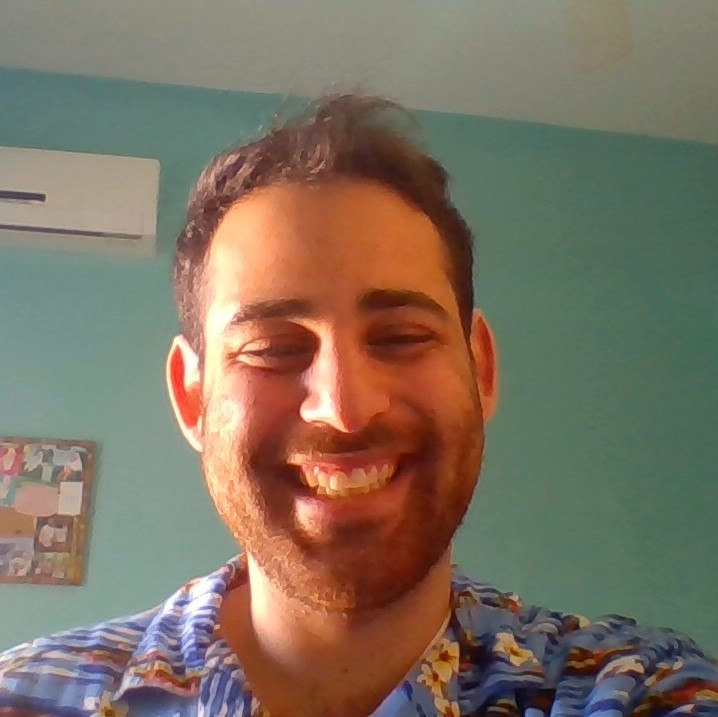



1/1 [==============================] - 0s 29ms/step
happy


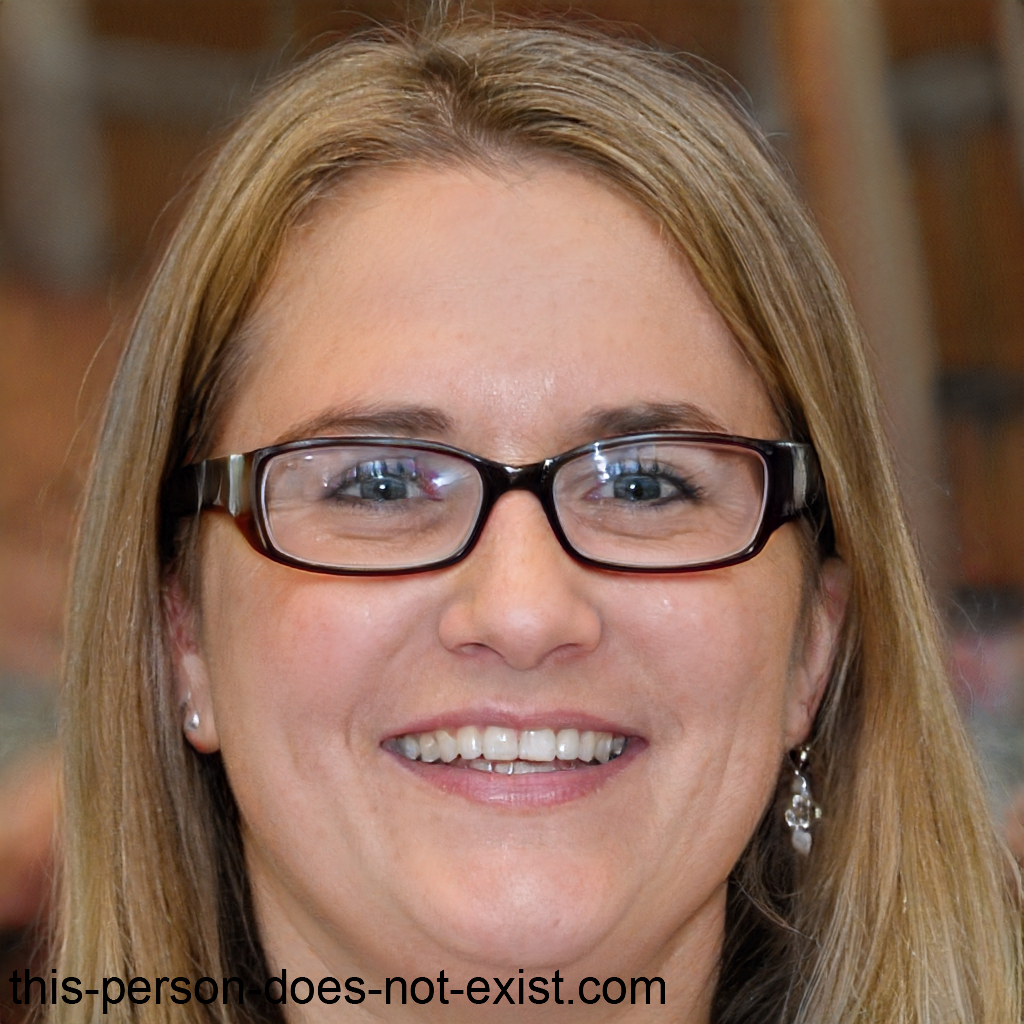



1/1 [==============================] - 0s 31ms/step
neutral


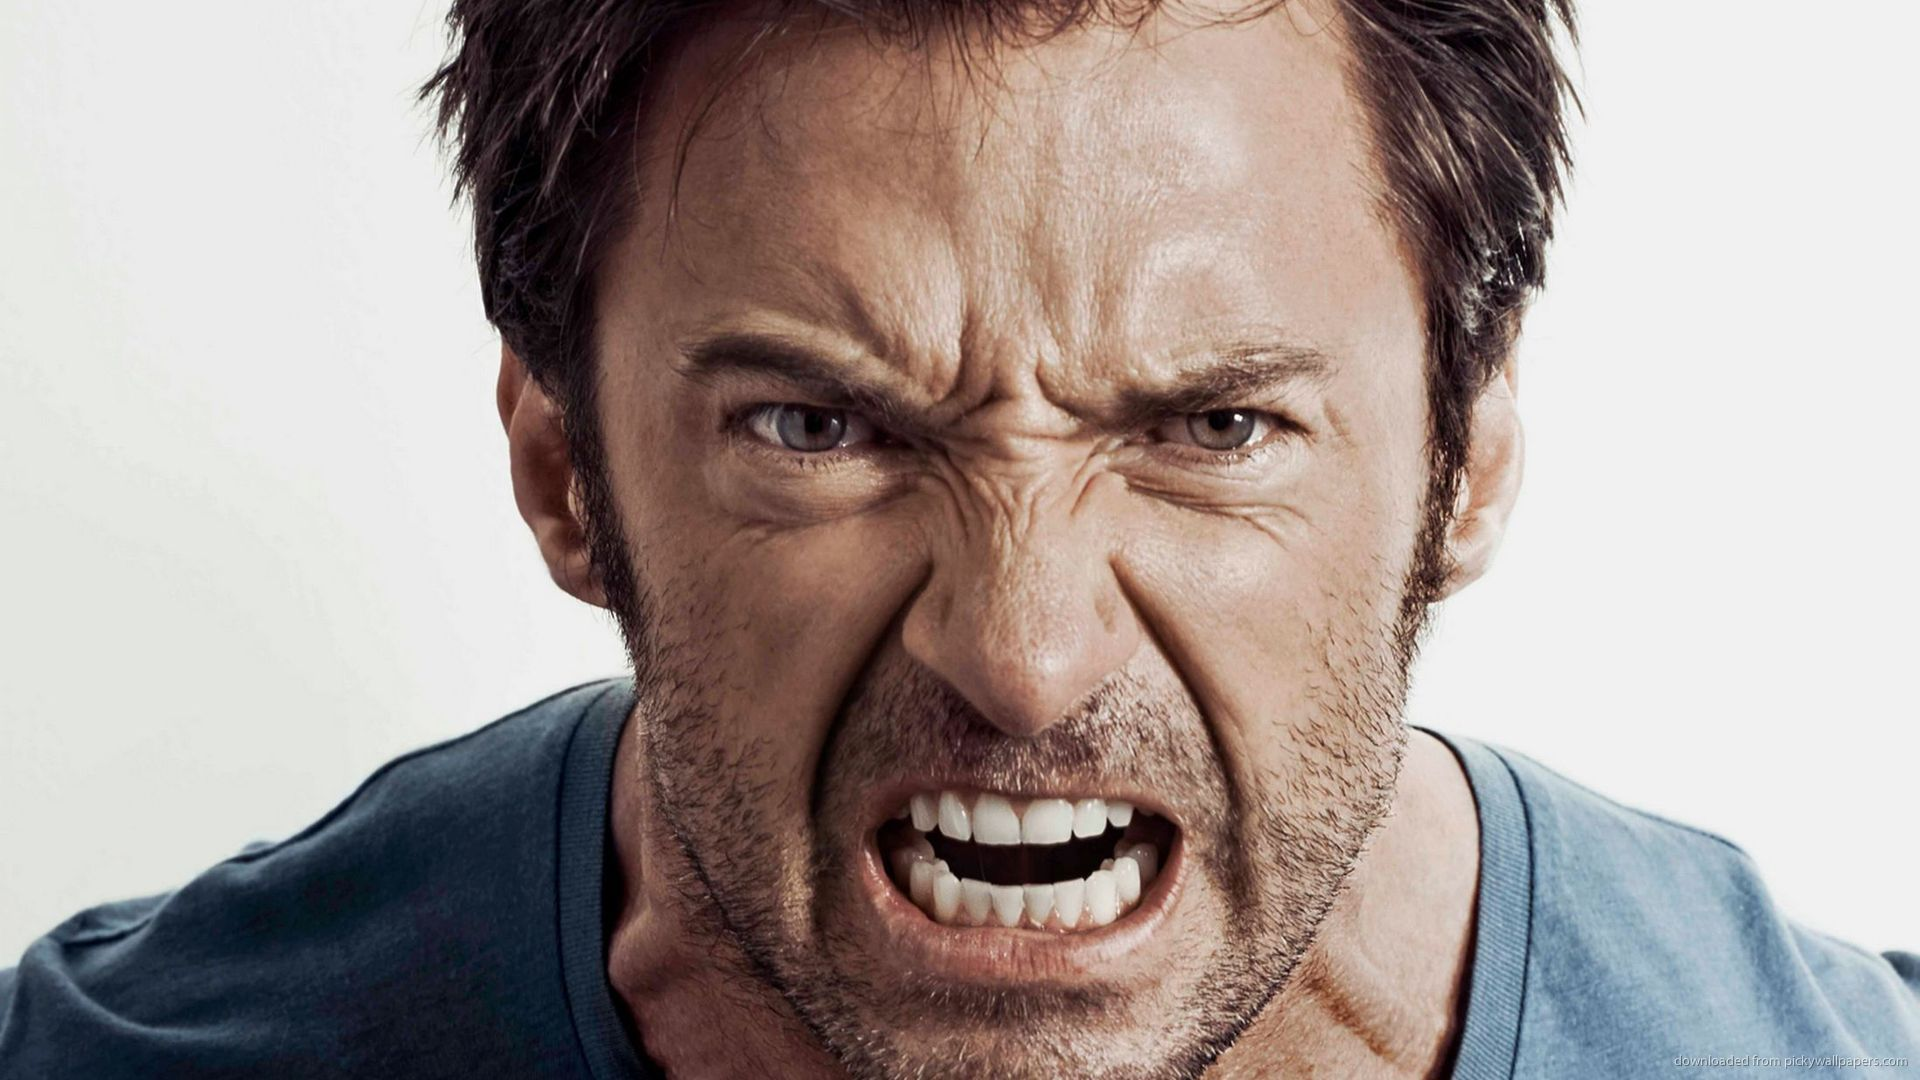



1/1 [==============================] - 0s 33ms/step
neutral


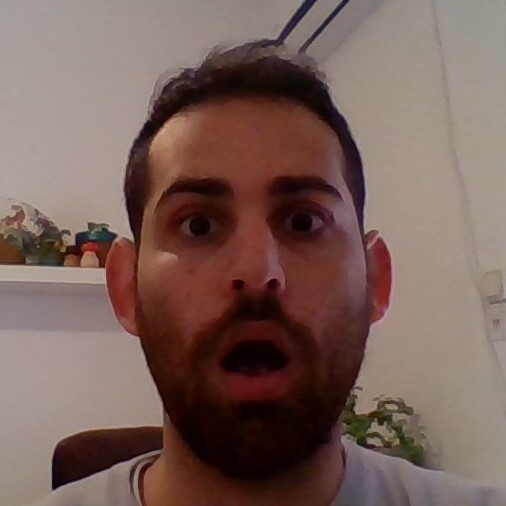



1/1 [==============================] - 0s 31ms/step
happy


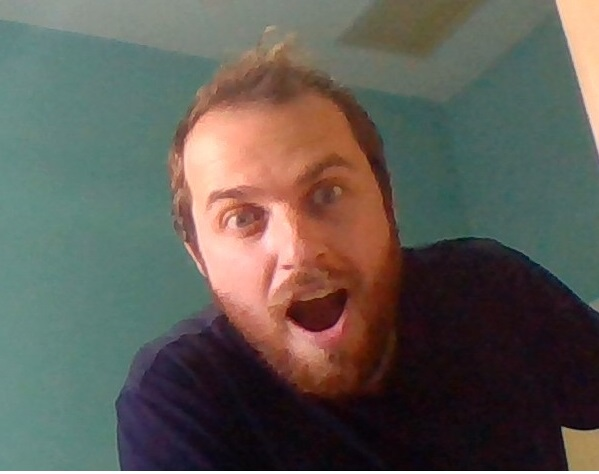



1/1 [==============================] - 0s 35ms/step
happy


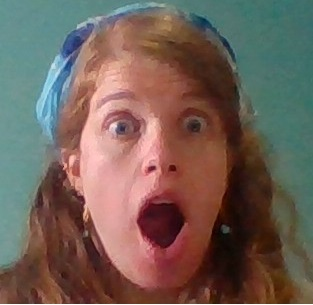



1/1 [==============================] - 0s 31ms/step
happy


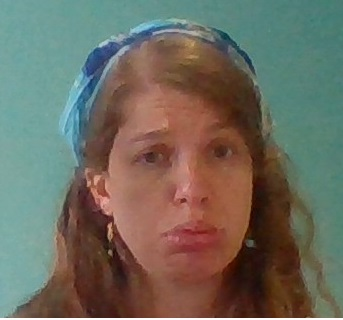



1/1 [==============================] - 0s 36ms/step
happy


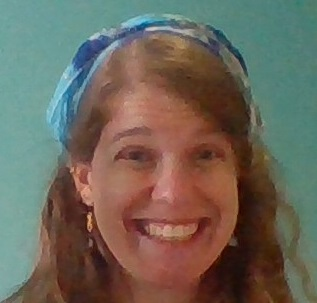



1/1 [==============================] - 0s 39ms/step
happy


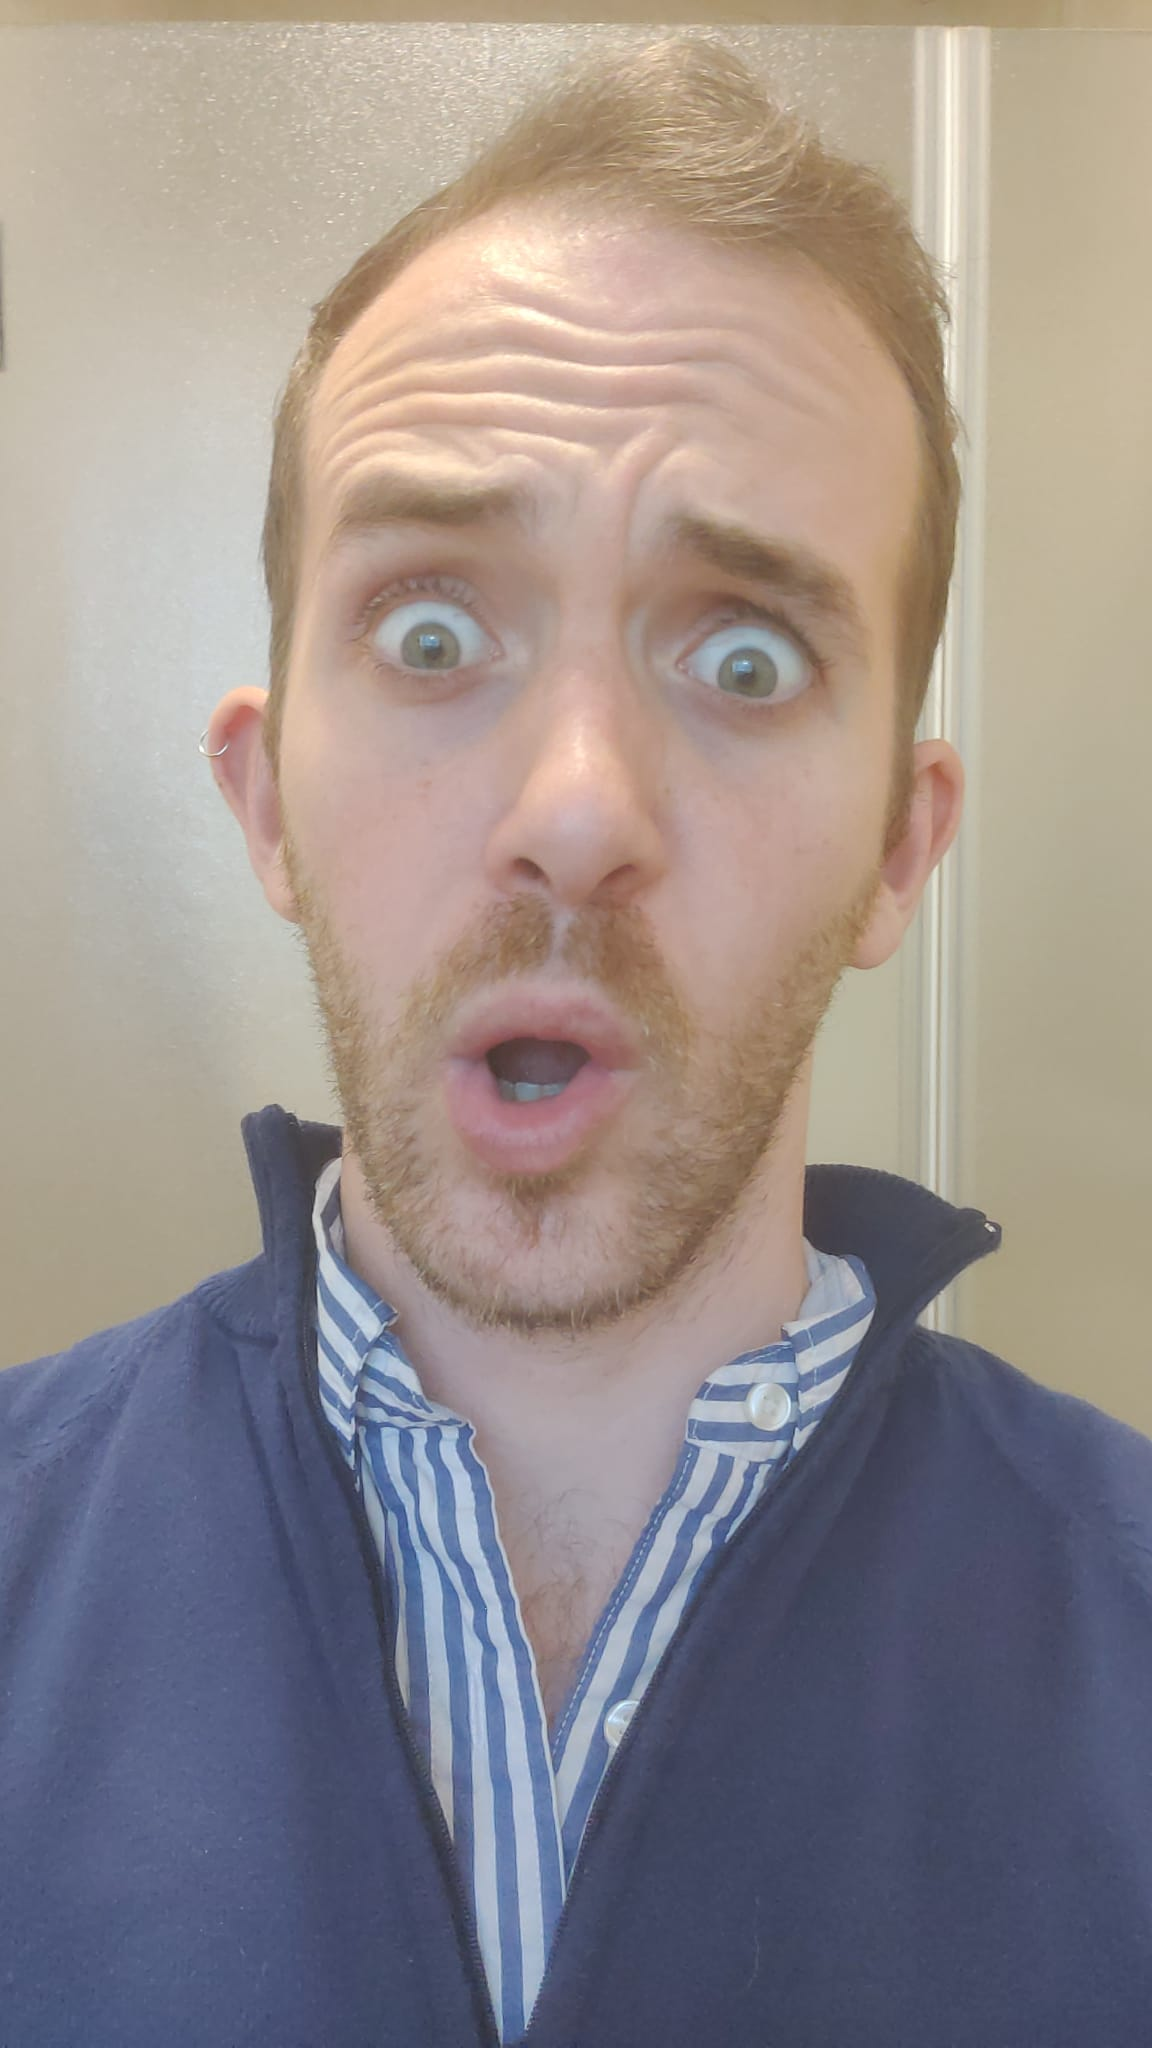



1/1 [==============================] - 0s 33ms/step
neutral


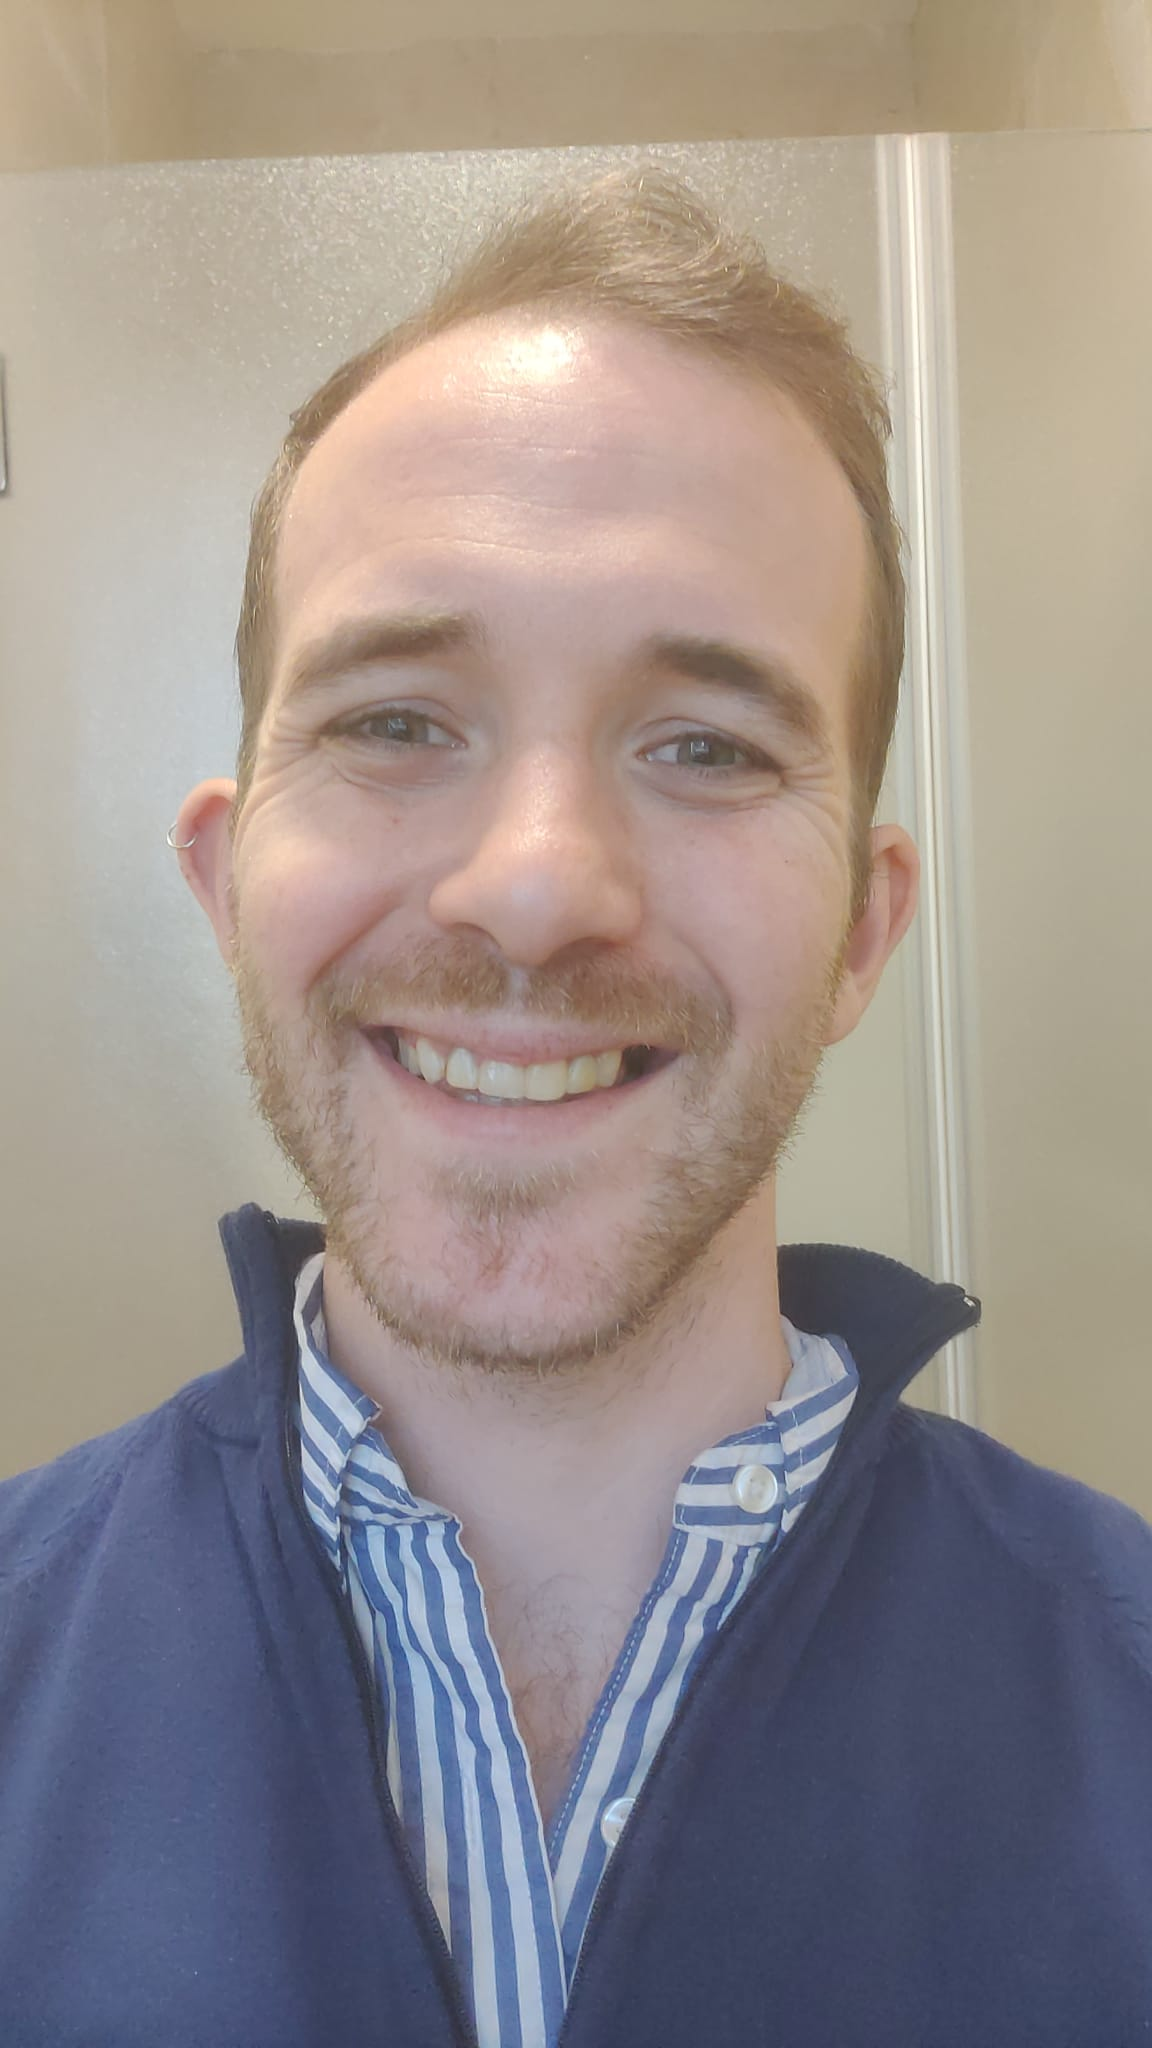



1/1 [==============================] - 0s 33ms/step
happy


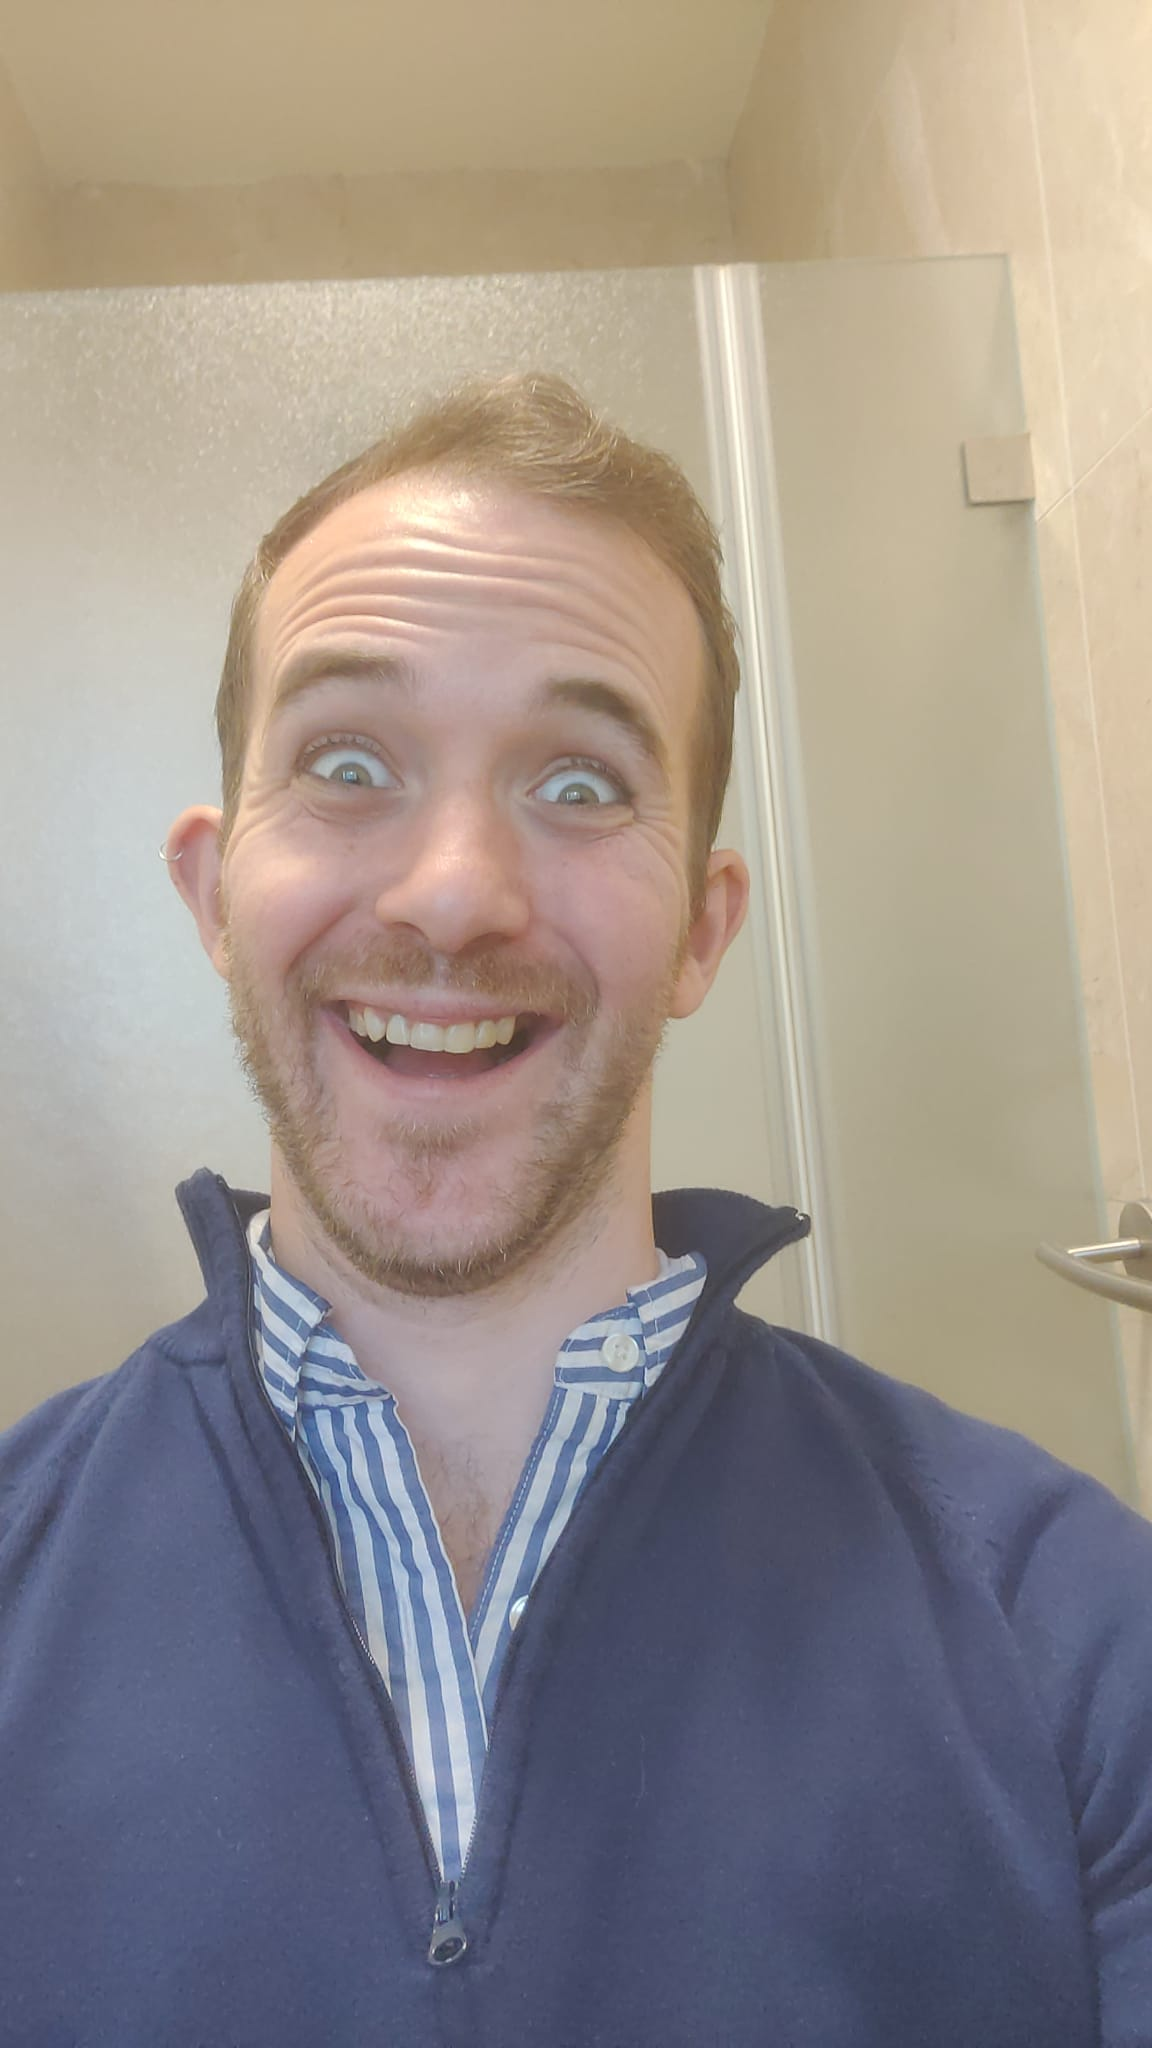

In [19]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import load_img,img_to_array


for i in range (1,12):
  img_directory = '/content/drive/MyDrive/fer/'+str(i)+'.jpg'
  img_data = load_img(img_directory, target_size = (48, 48))   #load the image from the directory
  img_data = img_to_array(img_data)                            #convert the image to a Numpy array
  img_data = tf.image.rgb_to_grayscale(img_data)
  img_data = np.expand_dims(img_data, axis = 0)                     #expands the array by inserting a new axis at the specified position.

  #predicting and printing prediction and picture 
  classify = best_model.predict(img_data)
  max_index = np.argmax(classify[0])
  emotion_detection = ('angry', 'fear', 'happy', 'sad', 'surprised', 'neutral')
  emotion_prediction = emotion_detection[max_index]  
  print(emotion_prediction)
  
  display(Image(img_directory,width= 150, height=150))
  print("\n")
 


# Saving the model

Third section is for saving the weights of the neural network into a file so we wouldn't have to train the model every time we use the face recognition

We will serialize the model to JSON and save the model's weights in a hd5 file, so we can use it to make predictions directly without retraining the model everytime.



In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/cxcy-model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("/content/drive/MyDrive/cxcy-model.h5")

print("Saved model to drive - file can be located in the colab notebook inside 'content' folder")